In [1]:
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, MinMaxScaler, OneHotEncoder

# grisearchCV
from sklearn.model_selection import GridSearchCV

# train_test_split
from sklearn.model_selection import train_test_split

# classification models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

# metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report, precision_score, recall_score

# files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# Movies

Reading the `movies.csv` file

In [2]:
movies = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

In [3]:
movies.head(2)

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN


In [4]:
movies.shape  # dimensions of the dataframe

(143258, 14)

In [5]:
movies.info()  # overview of data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


# EDA and Preprocessing on `movies`

## Dropping unimportant Columns 

In [6]:
print('dropping columns...')
time.sleep(2)
movies.drop(columns=['releaseDateTheaters', 
                     'releaseDateStreaming', 
                     'originalLanguage', 
                     'director', 
                     'boxOffice', 
                     'distributor', 
                     'soundType',
                     'ratingContents'], inplace = True)
print('columns dropped')

dropping columns...
columns dropped


In [7]:
movies.columns # get the remaining columns

Index(['movieid', 'title', 'audienceScore', 'rating', 'runtimeMinutes',
       'genre'],
      dtype='object')

In [8]:
movies.isnull().sum()  # checking for null values in each column

movieid                0
title                  0
audienceScore      70010
rating            129267
runtimeMinutes     13827
genre              11083
dtype: int64

In [9]:
movies['movieid'].value_counts()  # checking for duplicate movieids

escape_the_terminator_tyler_durden_astonish         367
silent_mystery_the_terminator                        17
crimson_james_t._kirk_marty_mcfly_hulk               17
darth_vader_dazzling_courageous_holly_golightly      16
rocky_balboa_wonder_woman_majestic_emerald           16
                                                   ... 
anakin_skywalker_frodo_baggins_t-800_black_widow      1
phantom_hannibal_lecter_don_vito_corleone_pirate      1
v_bruce_wayne_stardust                                1
mystery_lara_croft_tony_montana                       1
wonder_hermione_granger_hulk_v                        1
Name: movieid, Length: 126404, dtype: int64

## Outliers?? Not Really

This step will be handled after merging `movies.csv` with `train.csv`

<Axes: ylabel='runtimeMinutes'>

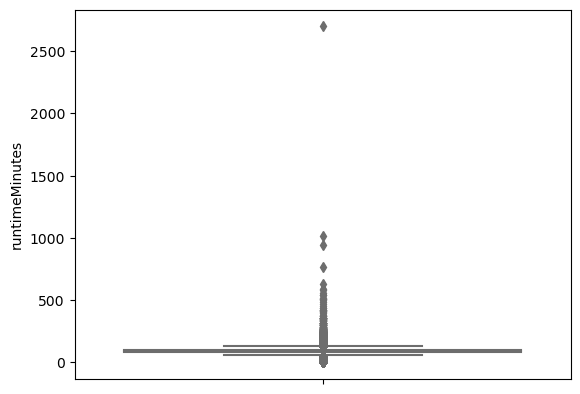

In [10]:
sns.boxplot(data = movies, y='runtimeMinutes', color='salmon')

## No problem with `audienceScore`

<Axes: ylabel='audienceScore'>

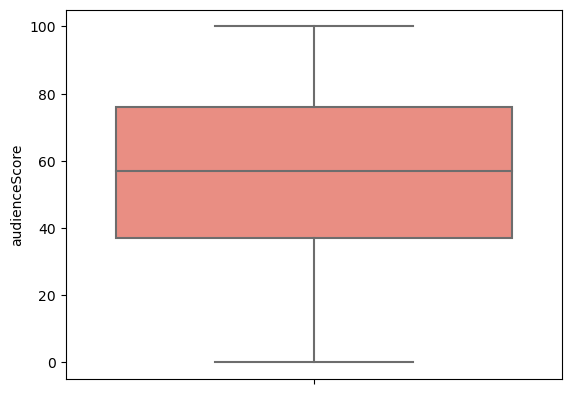

In [11]:
sns.boxplot(data=movies, y='audienceScore', color='salmon')

### `movieid` column has duplicate values and each row has a different set of values. Aggregate them


In [12]:
movies[movies['movieid']=='silent_mystery_the_terminator']

,movieid,title,audienceScore,rating,runtimeMinutes,genre
15649,silent_mystery_the_terminator,Silent Mystery The Terminator,21.0,R,90.0,"Action, Mystery & thriller"
35010,silent_mystery_the_terminator,Silent Mystery The Terminator,0.0,NaN,100.0,Sci-fi
45236,silent_mystery_the_terminator,Silent Mystery The Terminator,97.0,NaN,120.0,Drama
47556,silent_mystery_the_terminator,Silent Mystery The Terminator,NaN,NaN,15.0,"Drama, Mystery & thriller"
53301,silent_mystery_the_terminator,Silent Mystery The Terminator,81.0,NaN,95.0,Mystery & thriller
59002,silent_mystery_the_terminator,Silent Mystery The Terminator,68.0,NaN,117.0,"Crime, Drama, Mystery & thriller"
64469,silent_mystery_the_terminator,Silent Mystery The Terminator,NaN,NaN,82.0,Documentary
68314,silent_mystery_the_terminator,Silent Mystery The Terminator,50.0,NaN,88.0,Mystery & thriller
78370,silent_mystery_the_terminator,Silent Mystery The Terminator,NaN,NaN,96.0,Drama
83611,silent_mystery_the_terminator,Silent Mystery The Terminator,69.0,NaN,105.0,Drama


### Converting `genre` and `rating` to lists

`Action, Mystery & thriller` will be converted to `[Action, Mystery, Thriller]`

In [13]:
print('conversion in progress...')
time.sleep(2)
def convert_to_list(x):
    '''splits a string of values based on given pattern and converts it to a list'''
    if type(x)==str:
        pattern = r'\s*&\s*|\s*,\s*|\s*-\s*'
        x = re.split(pattern, x)
        return [x.strip() for x in x]
    else:
        return []

movies['genre']=movies['genre'].apply(lambda x: convert_to_list(x))
movies['rating']=movies['rating'].apply(lambda x: [x.strip()] if type(x) == str else [])
print('conversion completed')

conversion in progress...
conversion completed


In [14]:
movies[movies['movieid']=='silent_mystery_the_terminator']

,movieid,title,audienceScore,rating,runtimeMinutes,genre
15649,silent_mystery_the_terminator,Silent Mystery The Terminator,21.0,[R],90.0,"[Action, Mystery, thriller]"
35010,silent_mystery_the_terminator,Silent Mystery The Terminator,0.0,[],100.0,"[Sci, fi]"
45236,silent_mystery_the_terminator,Silent Mystery The Terminator,97.0,[],120.0,[Drama]
47556,silent_mystery_the_terminator,Silent Mystery The Terminator,NaN,[],15.0,"[Drama, Mystery, thriller]"
53301,silent_mystery_the_terminator,Silent Mystery The Terminator,81.0,[],95.0,"[Mystery, thriller]"
59002,silent_mystery_the_terminator,Silent Mystery The Terminator,68.0,[],117.0,"[Crime, Drama, Mystery, thriller]"
64469,silent_mystery_the_terminator,Silent Mystery The Terminator,NaN,[],82.0,[Documentary]
68314,silent_mystery_the_terminator,Silent Mystery The Terminator,50.0,[],88.0,"[Mystery, thriller]"
78370,silent_mystery_the_terminator,Silent Mystery The Terminator,NaN,[],96.0,[Drama]
83611,silent_mystery_the_terminator,Silent Mystery The Terminator,69.0,[],105.0,[Drama]


### Grouping the rows by `movieid` and performing aggregation
  * grouping rows using pandas `groupby` function
 
  * aggregation done using pandas `agg` function

In [15]:
print("aggregation in progess.....")
grouping = movies.groupby('movieid').agg({
    'audienceScore' : 'mean',
    'runtimeMinutes' : 'max',
    'genre' : 'sum',
    'rating' : 'sum'
}).reset_index()
print("aggregation completed")

aggregation in progess.....
aggregation completed


In [16]:
grouping[grouping['movieid']=='silent_mystery_the_terminator'] # verifying

,movieid,audienceScore,runtimeMinutes,genre,rating
98757,silent_mystery_the_terminator,50.222222,120.0,"[Action, Mystery, thriller, Sci, fi, Drama, Dr...",[R]


### Removing duplicate values of genre from list
 `[ Action, Action, Drama, Drama, Thriller ]` will be converted to `[ Action, Drama, Thriller ]`

In [17]:
print('removing duplicates...')
time.sleep(1)
def remove_duplicates(x):
    '''Removes duplicates and convert the text to lower'''
    return list(set([x.lower() for x in x]))
time.sleep(1)
grouping['genre'] = grouping['genre'].apply(lambda x : remove_duplicates(x))
print('duplicates removed')

removing duplicates...
duplicates removed


### Classifying the `rating` column and creating a new column `parentalGuidance`
 - Set value as `True` if it has any of `[R, NC-17, PG-13]` else `False`
 
 - Rename the column to `parentalGuidance`

In [18]:
print('classification in progress...')
time.sleep(2)
def parental_guidance(x):
    '''Classifies the rating to True or False values'''
    if ('R' in x) or ('NC-17' in x) or ('PG-13' in x):
        return True
    return False

grouping['rating'] = grouping['rating'].apply(lambda x : parental_guidance(x))
print('classification completed')
print('renaming columns')
time.sleep(1.5)
grouping.rename(columns={'rating':'parentalGuidance'}, inplace=True)
print("renamed 'rating' to 'parentalGuidance'")

classification in progress...
classification completed
renaming columns
renamed 'rating' to 'parentalGuidance'


In [19]:
grouping[grouping['movieid']=='silent_mystery_the_terminator']

,movieid,audienceScore,runtimeMinutes,genre,parentalGuidance
98757,silent_mystery_the_terminator,50.222222,120.0,"[biography, action, drama, documentary, thrill...",True


In [20]:
grouping.head()

,movieid,audienceScore,runtimeMinutes,genre,parentalGuidance
0,adventure_anakin_skywalker,49.0,96.0,[comedy],False
1,adventure_anakin_skywalker_chronicles_whisper,NaN,90.0,[drama],False
2,adventure_astonish,40.0,90.0,[comedy],False
3,adventure_astonish_wondrous_beneath,60.0,96.0,[romance],False
4,adventure_aurora_epic,NaN,60.0,[drama],False


In [21]:
grouping['parentalGuidance'].value_counts()

False    115649
True      10755
Name: parentalGuidance, dtype: int64

In [22]:
grouping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126404 entries, 0 to 126403
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieid           126404 non-null  object 
 1   audienceScore     66187 non-null   float64
 2   runtimeMinutes    114448 non-null  float64
 3   genre             126404 non-null  object 
 4   parentalGuidance  126404 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 4.0+ MB


### Dropping duplicate values of `movieid`

In [23]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movieid         143258 non-null  object 
 1   title           143258 non-null  object 
 2   audienceScore   73248 non-null   float64
 3   rating          143258 non-null  object 
 4   runtimeMinutes  129431 non-null  float64
 5   genre           143258 non-null  object 
dtypes: float64(2), object(4)
memory usage: 6.6+ MB


In [24]:
movies.drop_duplicates(['movieid'], inplace=True)

In [25]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126404 entries, 0 to 143256
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   movieid         126404 non-null  object 
 1   title           126404 non-null  object 
 2   audienceScore   63714 non-null   float64
 3   rating          126404 non-null  object 
 4   runtimeMinutes  113910 non-null  float64
 5   genre           126404 non-null  object 
dtypes: float64(2), object(4)
memory usage: 6.8+ MB


### Also dropping `audienceScore, rating, genre, runtimeMinutes` 

In [26]:
movies.drop(columns=['audienceScore', 'rating', 'genre', 'runtimeMinutes'], inplace = True)

In [27]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126404 entries, 0 to 143256
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   movieid  126404 non-null  object
 1   title    126404 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


### Merging `movies` and `grouping` on `movieid`

In [28]:
print('merging in progress...')
time.sleep(2)
movies = pd.merge(movies, grouping, on='movieid', how='left')
print('merged movies and grouping dataframes')

merging in progress...
merged movies and grouping dataframes


In [29]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126404 entries, 0 to 126403
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieid           126404 non-null  object 
 1   title             126404 non-null  object 
 2   audienceScore     66187 non-null   float64
 3   runtimeMinutes    114448 non-null  float64
 4   genre             126404 non-null  object 
 5   parentalGuidance  126404 non-null  bool   
dtypes: bool(1), float64(2), object(3)
memory usage: 5.9+ MB


In [30]:
movies.head(2)

,movieid,title,audienceScore,runtimeMinutes,genre,parentalGuidance
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,75.0,"[horror, fi, comedy, sci]",False
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,114.0,[drama],False


# Train and Test

**Reading `train.csv` and `test.csv`**

In [31]:
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')

In [32]:
train.columns  # columns of train data

Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment'],
      dtype='object')

In [33]:
test.columns  # columns of test data

Index(['movieid', 'reviewerName', 'isTopCritic', 'reviewText'], dtype='object')

**Renaming `isFrequentReviewer` column in train data to `isTopCritic`**

In [34]:
print('rename in progress..')
time.sleep(2)
train.rename(columns={'isFrequentReviewer':'isTopCritic'}, inplace=True) # renaming using pandas rename function
print("renamed 'isFrequentReviewer' to 'isTopCritic'")

rename in progress..
renamed 'isFrequentReviewer' to 'isTopCritic'


In [35]:
train.columns  # verifying column names

Index(['movieid', 'reviewerName', 'isTopCritic', 'reviewText', 'sentiment'], dtype='object')

### Merging `train` and `test` with `movies`

In [36]:
print("merging 'train' and 'movies'...")
time.sleep(1)
train = pd.merge(train, movies, on='movieid', how='left')
print("merged 'train' and 'movies'")
time.sleep(0.5)
print("merging 'test' and 'movies'...")
time.sleep(1)
test = pd.merge(test, movies, on='movieid', how='left')
print("merged 'test' and 'movies'")

merging 'train' and 'movies'...
merged 'train' and 'movies'
merging 'test' and 'movies'...
merged 'test' and 'movies'


### Exploratory Data Analysis on `train`

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   movieid           162758 non-null  object 
 1   reviewerName      162758 non-null  object 
 2   isTopCritic       162758 non-null  bool   
 3   reviewText        156311 non-null  object 
 4   sentiment         162758 non-null  object 
 5   title             162758 non-null  object 
 6   audienceScore     159922 non-null  float64
 7   runtimeMinutes    162016 non-null  float64
 8   genre             162758 non-null  object 
 9   parentalGuidance  162758 non-null  bool   
dtypes: bool(2), float64(2), object(6)
memory usage: 11.5+ MB


**Studying the Distribution of `sentiments`**

In [38]:
train['sentiment'].value_counts()

POSITIVE    108761
NEGATIVE     53997
Name: sentiment, dtype: int64

In [39]:
train['sentiment'].value_counts(normalize=True)

POSITIVE    0.668238
NEGATIVE    0.331762
Name: sentiment, dtype: float64

### `sentiment` contains only two classes
- Positive
- Negative

So, we can go with `LabelEncoder` 

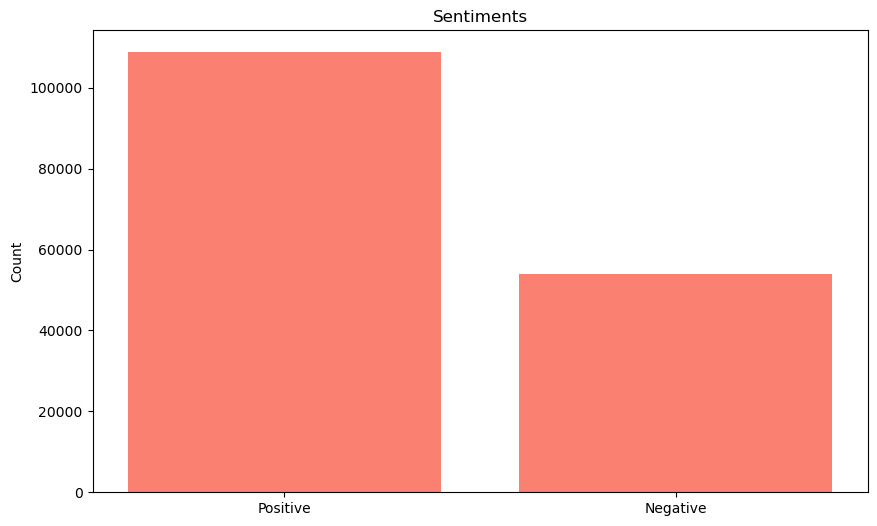

In [40]:
sentiments = train['sentiment'].value_counts()

positive = sentiments[0]
negative = sentiments[1]

plt.figure(figsize=(10,6))
plt.bar(['Positive', 'Negative'],[positive, negative], color='salmon')
plt.title('Sentiments')
plt.ylabel('Count')
plt.show()

**Studying the distribution of `Critics`**

In [41]:
train['isTopCritic'].value_counts()

False    113189
True      49569
Name: isTopCritic, dtype: int64

In [42]:
train['isTopCritic'].value_counts(normalize=True)

False    0.695444
True     0.304556
Name: isTopCritic, dtype: float64

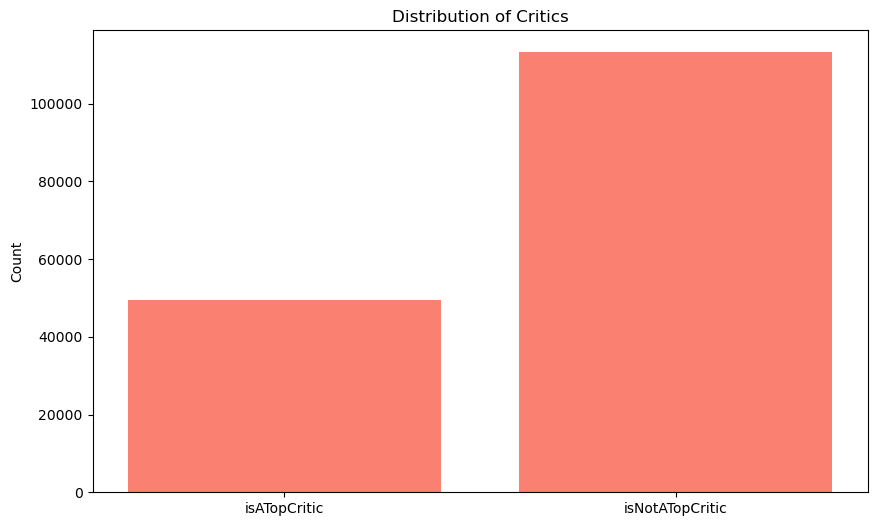

In [43]:
critics = train['isTopCritic'].value_counts()

isATopCritic = critics[1]
isNotATopCritic = critics[0]

plt.figure(figsize=(10,6))
plt.bar(['isATopCritic', 'isNotATopCritic'],[isATopCritic,isNotATopCritic], color='salmon')
plt.title('Distribution of Critics')
plt.ylabel('Count')
plt.show()

### `runtimetimes` looks much better now after performing `Datacleaning` and `EDA`

<Axes: ylabel='runtimeMinutes'>

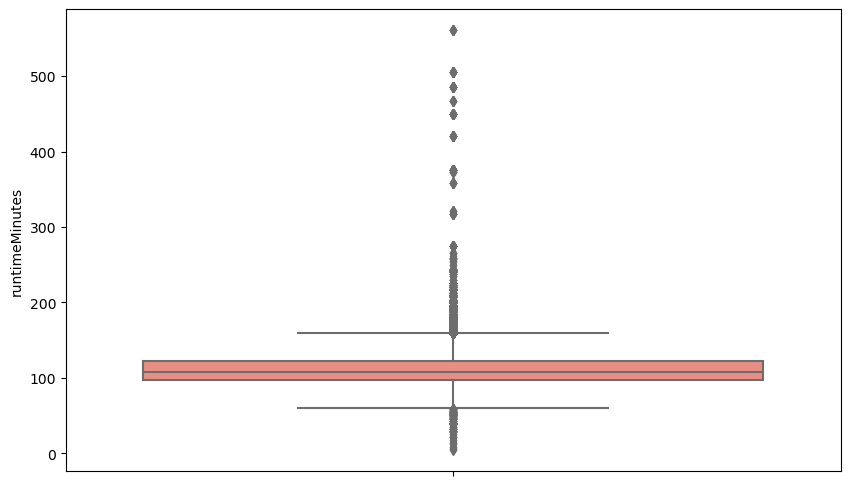

In [44]:
plt.figure(figsize=(10,6))
sns.boxplot(data=train, y='runtimeMinutes', color='salmon')

<Axes: ylabel='audienceScore'>

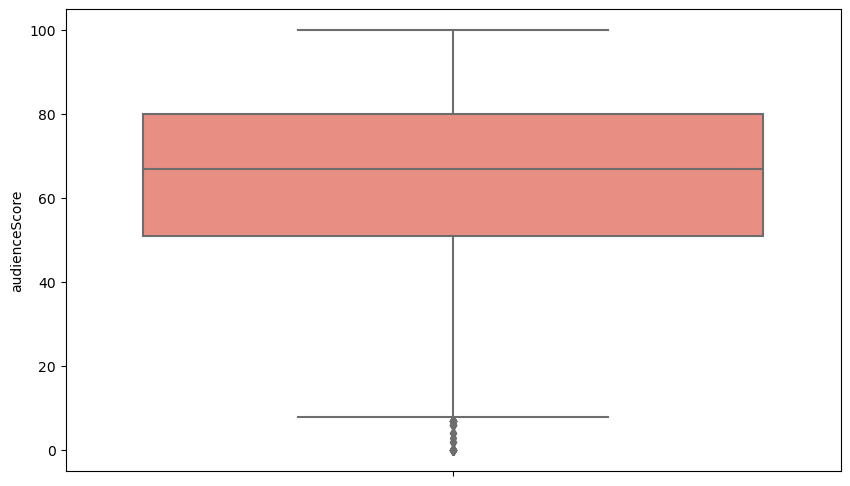

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(data=train, y='audienceScore', color='salmon')

In [46]:
train[['runtimeMinutes', 'audienceScore']].corr()

,runtimeMinutes,audienceScore
runtimeMinutes,1.000000,0.182472
audienceScore,0.182472,1.000000


We can see a positive correlation between `audienceScore` and `runtimeMinutes`

<Axes: >

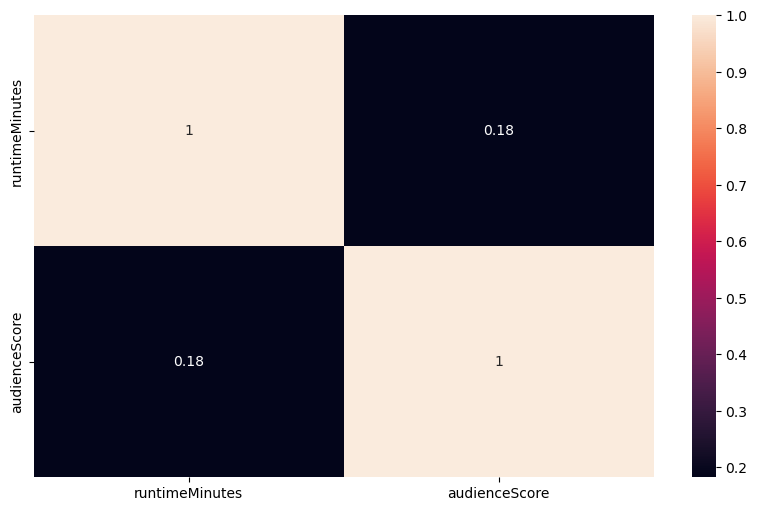

In [47]:
plt.figure(figsize=(10,6))
sns.heatmap(train[['runtimeMinutes', 'audienceScore']].corr(), annot=True)

## Genre By Frequency

getting freq count of genres...
getting top 20 genres..
plotting graph..


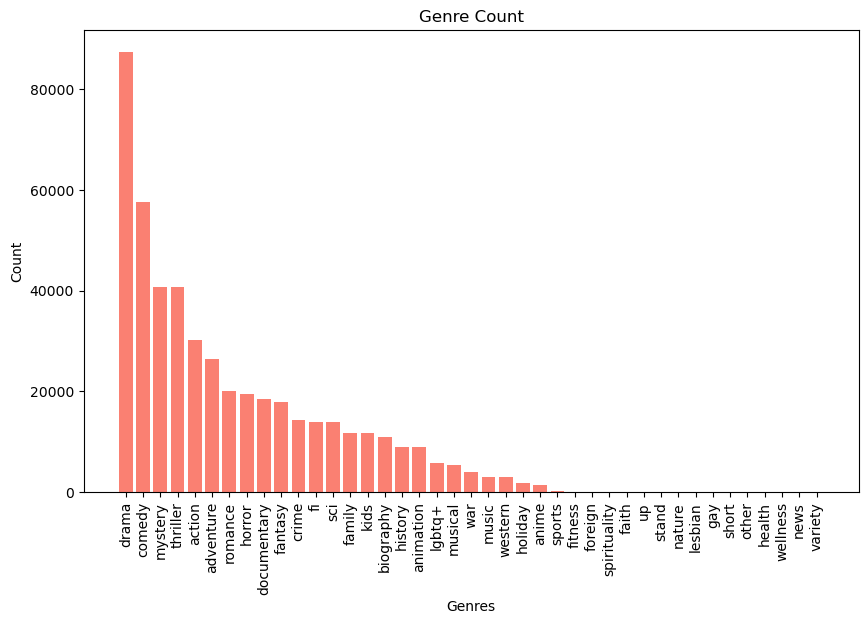

In [48]:
print("getting freq count of genres...")
time.sleep(2)
genreFrequency = {}
for genreList in train['genre']:
    for genre in genreList:
        if genre in genreFrequency.keys():
            genreFrequency[genre] += 1
        else:
            genreFrequency[genre] = 1

print('getting top 20 genres..')
time.sleep(1)
sorted_genres = sorted(genreFrequency.items(), key = lambda x:x[1], reverse=True)
genres, counts = [], []
for genre, count in sorted_genres:
    genres.append(genre)
    counts.append(count)

print('plotting graph..')
plt.figure(figsize=(10,6))
plt.bar(genres, counts, color='salmon')
plt.title('Genre Count')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [49]:
train['reviewText'].fillna("sample review", inplace=True)
test['reviewText'].fillna("sample review", inplace=True)

In [50]:
train.columns

Index(['movieid', 'reviewerName', 'isTopCritic', 'reviewText', 'sentiment',
       'title', 'audienceScore', 'runtimeMinutes', 'genre',
       'parentalGuidance'],
      dtype='object')

### Splitting the data into features and label
  - `X` represents features 
  
  -  `y` represents label i.e., `sentiment` of the review

In [51]:
X = train.drop('sentiment',axis=1)
y = train['sentiment']

In [52]:
X.head(2)

,movieid,reviewerName,isTopCritic,reviewText,title,audienceScore,runtimeMinutes,genre,parentalGuidance
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,Marvelous Pirate,65.0,105.0,"[adventure, fantasy, comedy, animation]",True
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,Tony Montana Frodo Baggins V Rocky Balboa,47.0,119.0,"[holiday, lgbtq+, comedy, action, romance]",True


In [53]:
y[:5]

0    POSITIVE
1    NEGATIVE
2    POSITIVE
3    POSITIVE
4    POSITIVE
Name: sentiment, dtype: object

### Label Encoding `y`

In [54]:
y = LabelEncoder().fit_transform(y)

In [55]:
y

array([1, 0, 1, ..., 1, 0, 1])

## Creating a Custom Wrapper Class 
  To handle `TypeError: fit_transform() takes 2 positional arguments but 3 were given` while using LabelBinarizer in Pipeline.

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer

class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. It makes it accept multiple inputs.

    Note that the input `X` has to be a `pandas.DataFrame`.
    """

    def __init__(self, ) -> None:
        self.binarizer_creator = MultiLabelBinarizer
        self.dtype = None

        self.binarizers = []
        self.categories_ = self.classes_ = []
        self.columns = []

    def fit(self, X: pd.DataFrame, y=None):  # noqa
        self.columns = X.columns.to_list()

        for column_name in X:
            binarizer = self.binarizer_creator().fit(X[column_name])
            self.binarizers.append(binarizer)
            self.classes_.append(binarizer.classes_)  # noqa

        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        if len(self.classes_) != X.shape[1]:
            raise ValueError(f"The fit transformer deals with {len(self.classes_)} columns "
                             f"while the input has {X.shape[1]}.")

        # print(self.classes_)
        return np.concatenate([binarizer.transform(X[c]).astype(self.dtype)
                               for c, binarizer in zip(X, self.binarizers)], axis=1)

### Data Preprocessing
 - `TfidfVectorizer` - Converting text columns to numerical values
 
 - `OneHotEncoder` - Converting `True` and `False` to `0` and `1` Respectively
 
 - `MinMaxScaler` - Scaling Numerical Values

In [57]:
vectorizer = TfidfVectorizer(
    stop_words=['english'],
    lowercase=False,
    min_df=5,
    )
encoder = OneHotEncoder()
scaler = MinMaxScaler()

In [58]:
X.columns

Index(['movieid', 'reviewerName', 'isTopCritic', 'reviewText', 'title',
       'audienceScore', 'runtimeMinutes', 'genre', 'parentalGuidance'],
      dtype='object')

### Creating pipelines for `runtime` and `audience` columns
  - `runtimeMinutes` - Filling the missing values with a constant value of `100` minutes
  
  - `audienceScore` - Filling the missing values with `mean`
   
  - And, Scaling the values using `MinMaxScaler()`
    

In [59]:
print("creating pipeline for 'runtimeMinutes'...")
time.sleep(2)

runtime = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value=100.0)),  # 'runtimeMinutes' pipeline
    ('scale', MinMaxScaler())
])

print("pipeline created for 'runtimeMinutes'")
time.sleep(1)
print("creating pipeline for 'audienceScore'...")
time.sleep(2)

audience = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),      # 'audienceScore' pipeline
    ('scale', MinMaxScaler())
])

print("pipeline created for 'audienceScore'")

creating pipeline for 'runtimeMinutes'...
pipeline created for 'runtimeMinutes'
creating pipeline for 'audienceScore'...
pipeline created for 'audienceScore'


### Preprocessor

In [60]:
print('preprocessing in progress...')
time.sleep(3)
print('vectorizing movieid...')
time.sleep(1)
print('vectorizing reviewText...')
time.sleep(1)
print('vectorizing title...')
time.sleep(1)
print('vectorizing reviewerName...')
time.sleep(2)
print('encoding isTopCritic...')
time.sleep(1)
print('encoding parentalGuidance')
time.sleep(1)
print('encoding genres')
time.sleep(2)
print('scaling runtimeMinutes and audienceScore')


preprocessor = ColumnTransformer(transformers=[
    ('tfidf1', vectorizer, 'movieid'),
    ('tfidf2', vectorizer, 'reviewText'),
    ('tfidf3', vectorizer, 'title'),
    ('tfidf4', vectorizer, 'reviewerName'),
    ('ohe1', encoder, ['isTopCritic']),
    ('ohe2', encoder, ['parentalGuidance']),
    ('multi_label', MultiHotEncoder(), ['genre']),
    ('runtime', runtime, ['runtimeMinutes']),
    ('audience', audience, ['audienceScore'])
], remainder='passthrough')

print('preprocessing completed')

preprocessing in progress...
vectorizing movieid...
vectorizing reviewText...
vectorizing title...
vectorizing reviewerName...
encoding isTopCritic...
encoding parentalGuidance
encoding genres
scaling runtimeMinutes and audienceScore
preprocessing completed


# Training Models

## Mutlinomial NB

In [61]:
pipeline1 = Pipeline([
    ('preprocess', preprocessor), 
    ('classifier', MultinomialNB())
])

params_multinomialNB = {
    'classifier__alpha' : [0.1, 0.5, 1.0]
}

grid_search_NB = GridSearchCV(pipeline1, params_multinomialNB, scoring='f1', verbose=5)
grid_search_NB.fit(X,y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............classifier__alpha=0.1;, score=0.848 total time=   6.7s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END .............classifier__alpha=0.1;, score=0.850 total time=   6.8s
[CV 3/5] END .............classifier__alpha=0.1;, score=0.851 total time=   6.9s
[CV 4/5] END .............classifier__alpha=0.1;, score=0.848 total time=   6.8s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END .............classifier__alpha=0.1;, score=0.848 total time=   7.0s
[CV 1/5] END .............classifier__alpha=0.5;, score=0.849 total time=   6.9s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END .............classifier__alpha=0.5;, score=0.851 total time=   6.8s
[CV 3/5] END .............classifier__alpha=0.5;, score=0.852 total time=   6.8s
[CV 4/5] END .............classifier__alpha=0.5;, score=0.848 total time=   6.9s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END .............classifier__alpha=0.5;, score=0.850 total time=   6.7s
[CV 1/5] END .............classifier__alpha=1.0;, score=0.852 total time=   7.0s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END .............classifier__alpha=1.0;, score=0.853 total time=   6.9s
[CV 3/5] END .............classifier__alpha=1.0;, score=0.853 total time=   7.0s
[CV 4/5] END .............classifier__alpha=1.0;, score=0.850 total time=   7.6s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END .............classifier__alpha=1.0;, score=0.851 total time=   7.9s


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf1',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'movieid'),
                                                                        ('tfidf2',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'reviewText'),
                                                                        ('tfidf3',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['en...
                                                                         ['genre']),
                                                                        ('runtime',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(fill_value=100.0,
                                                                                                        strategy='constant')),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['runtimeMinutes']),
                                                                        ('audience',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['audienceScore'])])),
                                       ('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.1, 0.5, 1.0]}, scoring='f1',
             verbose=5)

In [62]:
grid_search_NB.best_score_

0.8517984040470346

In [63]:
grid_search_NB.best_params_

{'classifier__alpha': 1.0}

## Linear SVC

In [64]:
pipeline2 = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LinearSVC())
])

params_linearSVC = {
    'classifier__C': [0.1, 1],   
    'classifier__max_iter': [1000],  
}

grid_search_LSVC = GridSearchCV(pipeline2, params_linearSVC, scoring="f1", verbose=5)
grid_search_LSVC.fit(X,y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END classifier__C=0.1, classifier__max_iter=1000;, score=0.876 total time=  12.1s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__max_iter=1000;, score=0.877 total time=  12.0s
[CV 3/5] END classifier__C=0.1, classifier__max_iter=1000;, score=0.879 total time=  12.1s
[CV 4/5] END classifier__C=0.1, classifier__max_iter=1000;, score=0.876 total time=  12.3s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__max_iter=1000;, score=0.878 total time=  12.2s
[CV 1/5] END classifier__C=1, classifier__max_iter=1000;, score=0.867 total time=  35.0s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__max_iter=1000;, score=0.869 total time=  32.1s
[CV 3/5] END classifier__C=1, classifier__max_iter=1000;, score=0.869 total time=  31.2s
[CV 4/5] END classifier__C=1, classifier__max_iter=1000;, score=0.866 total time=  31.6s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__max_iter=1000;, score=0.868 total time=  31.1s


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf1',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'movieid'),
                                                                        ('tfidf2',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'reviewText'),
                                                                        ('tfidf3',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['en...
                                                                        ('runtime',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(fill_value=100.0,
                                                                                                        strategy='constant')),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['runtimeMinutes']),
                                                                        ('audience',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['audienceScore'])])),
                                       ('classifier', LinearSVC())]),
             param_grid={'classifier__C': [0.1, 1],
                         'classifier__max_iter': [1000]},
             scoring='f1', verbose=5)

In [65]:
grid_search_LSVC.best_score_

0.8771429357590599

In [66]:
grid_search_LSVC.best_params_

{'classifier__C': 0.1, 'classifier__max_iter': 1000}

## Logistic Regression

In [67]:
pipeline3 = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression())
])

params_LR = {
    'classifier__C': [0.1, 1],
    'classifier__max_iter': [1500 ],
    'classifier__solver': ['saga']
}

grid_search_LR = GridSearchCV(pipeline3, params_LR, scoring='f1', verbose=5)
grid_search_LR.fit(X,y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END classifier__C=0.1, classifier__max_iter=1500, classifier__solver=saga;, score=0.858 total time= 1.7min


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END classifier__C=0.1, classifier__max_iter=1500, classifier__solver=saga;, score=0.858 total time= 1.7min
[CV 3/5] END classifier__C=0.1, classifier__max_iter=1500, classifier__solver=saga;, score=0.861 total time= 1.6min
[CV 4/5] END classifier__C=0.1, classifier__max_iter=1500, classifier__solver=saga;, score=0.858 total time= 1.6min


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END classifier__C=0.1, classifier__max_iter=1500, classifier__solver=saga;, score=0.859 total time= 1.6min
[CV 1/5] END classifier__C=1, classifier__max_iter=1500, classifier__solver=saga;, score=0.875 total time=  17.7s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END classifier__C=1, classifier__max_iter=1500, classifier__solver=saga;, score=0.876 total time=  18.0s
[CV 3/5] END classifier__C=1, classifier__max_iter=1500, classifier__solver=saga;, score=0.878 total time=  18.0s
[CV 4/5] END classifier__C=1, classifier__max_iter=1500, classifier__solver=saga;, score=0.876 total time=  17.7s


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END classifier__C=1, classifier__max_iter=1500, classifier__solver=saga;, score=0.878 total time=  17.5s


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf1',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'movieid'),
                                                                        ('tfidf2',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'reviewText'),
                                                                        ('tfidf3',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['en...
                                                                                          SimpleImputer(fill_value=100.0,
                                                                                                        strategy='constant')),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['runtimeMinutes']),
                                                                        ('audience',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['audienceScore'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.1, 1],
                         'classifier__max_iter': [1500],
                         'classifier__solver': ['saga']},
             scoring='f1', verbose=5)

In [68]:
grid_search_LR.best_params_

{'classifier__C': 1,
 'classifier__max_iter': 1500,
 'classifier__solver': 'saga'}

In [69]:
grid_search_LR.best_score_

0.8765508422303989

## Random Forest Classifier

In [70]:
pipeline4 = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier())
])

params_RFC = {
    'classifier__n_estimators' : [128],
    'classifier__min_samples_split': [12],
    'classifier__min_samples_leaf' : [6, 8]
}
grid_search_RFC = GridSearchCV(pipeline4, params_RFC, scoring='f1', verbose=5)
grid_search_RFC.fit(X,y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END classifier__min_samples_leaf=6, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.826 total time= 1.8min


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END classifier__min_samples_leaf=6, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.828 total time= 1.8min
[CV 3/5] END classifier__min_samples_leaf=6, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.827 total time= 1.8min
[CV 4/5] END classifier__min_samples_leaf=6, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.825 total time= 1.8min


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END classifier__min_samples_leaf=6, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.824 total time= 1.7min
[CV 1/5] END classifier__min_samples_leaf=8, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.822 total time= 1.5min


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END classifier__min_samples_leaf=8, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.824 total time= 1.5min
[CV 3/5] END classifier__min_samples_leaf=8, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.823 total time= 1.5min
[CV 4/5] END classifier__min_samples_leaf=8, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.822 total time= 1.5min


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END classifier__min_samples_leaf=8, classifier__min_samples_split=12, classifier__n_estimators=128;, score=0.821 total time= 1.5min


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf1',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'movieid'),
                                                                        ('tfidf2',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'reviewText'),
                                                                        ('tfidf3',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['en...
                                                                                                        strategy='constant')),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['runtimeMinutes']),
                                                                        ('audience',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          MinMaxScaler())]),
                                                                         ['audienceScore'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__min_samples_leaf': [6, 8],
                         'classifier__min_samples_split': [12],
                         'classifier__n_estimators': [128]},
             scoring='f1', verbose=5)

In [71]:
grid_search_RFC.best_params_

{'classifier__min_samples_leaf': 6,
 'classifier__min_samples_split': 12,
 'classifier__n_estimators': 128}

In [72]:
grid_search_RFC.best_score_

0.8258465052980559

In [73]:
modelScores = {
    'MutlinomialNB' : grid_search_NB.best_score_,
    'LinearSVC' : grid_search_LSVC.best_score_,
    'Logistic Regression' : grid_search_LR.best_score_,
    'RandomForestClassifier' : grid_search_RFC.best_score_
}

## Visualizing and Comparing Scores

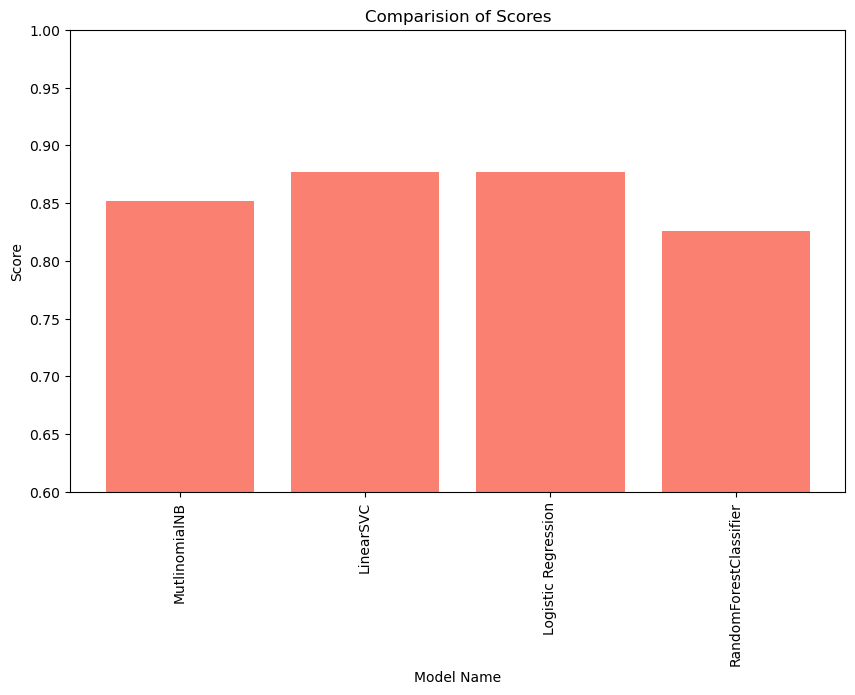

In [74]:
plt.figure(figsize=(10,6))
plt.bar(modelScores.keys(), modelScores.values(), color='salmon')
plt.xlabel('Model Name')
plt.ylabel('Score')
plt.title('Comparision of Scores')
plt.xticks(rotation=90)
plt.ylim(0.6,1)
plt.show()

### We Notice that `LinearSVC` and `LogisticRegression` perform the best among the chosen algorithms

Lets have a closer look at their mertics

#### LinearSVC

In [75]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state = 42)

In [76]:
lsvc_preds = grid_search_LSVC.best_estimator_.predict(X_test)
lsvc_preds

array([1, 0, 0, ..., 1, 1, 1])

In [77]:
print(classification_report(lsvc_preds, y_test))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      9512
           1       0.94      0.89      0.91     23040

    accuracy                           0.88     32552
   macro avg       0.85      0.87      0.86     32552
weighted avg       0.88      0.88      0.88     32552



#### Logistic Regression

In [78]:
lr_preds = grid_search_LR.best_estimator_.predict(X_test)
lr_preds

array([1, 0, 0, ..., 1, 1, 1])

In [79]:
print(classification_report(lr_preds, y_test))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      9512
           1       0.93      0.89      0.91     23040

    accuracy                           0.88     32552
   macro avg       0.85      0.87      0.86     32552
weighted avg       0.88      0.88      0.88     32552



#### Compare `accuracy`, `precision`, `recall`

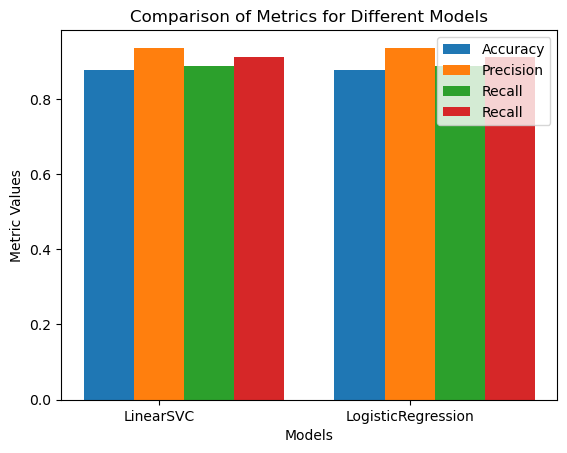

In [80]:
model_names = ['LinearSVC', 'LogisticRegression']

accuracy_values = [accuracy_score(lsvc_preds, y_test), accuracy_score(lr_preds, y_test)]
precision_values = [precision_score(lsvc_preds, y_test), precision_score(lr_preds, y_test)]
f1_values = [f1_score(lsvc_preds, y_test), f1_score(lr_preds, y_test)]
recall_values = [recall_score(lsvc_preds, y_test), recall_score(lr_preds, y_test)]

bar_width = 0.2

index = np.arange(len(model_names))

plt.bar(index, accuracy_values, width=bar_width, label='Accuracy')
plt.bar(index + bar_width, precision_values, width=bar_width, label='Precision')
plt.bar(index + 2 * bar_width, recall_values, width=bar_width, label='Recall')
plt.bar(index + 3 * bar_width, f1_values, width=bar_width, label='Recall')

plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('Comparison of Metrics for Different Models')
plt.xticks(index + bar_width, model_names)
plt.legend()
plt.show()

### Lets also try out `VotingClassifier`

In [81]:
estimators = [
    ('MutlinomialNB', MultinomialNB(alpha=0.1)),
    ('LogisticRegression', LogisticRegression( C=1, max_iter=1500, solver='saga')),
    ('RandomForestClassifier', RandomForestClassifier(n_estimators = 128, min_samples_leaf = 6, min_samples_split = 12))
]

In [82]:
voting = VotingClassifier(estimators = estimators)

In [83]:
voting_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('voting', voting)
])

params_voting = {
    'voting__voting' : ['soft'],
    'voting__weights' : [[1 , 2, 1]]
}

In [84]:
grid_search_voting = GridSearchCV(voting_pipeline, params_voting, scoring='f1', verbose=5)
grid_search_voting.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END voting__voting=soft, voting__weights=[1, 2, 1];, score=0.874 total time= 2.0min


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['news'] will be ignored
  warnings.warn(


[CV 2/5] END voting__voting=soft, voting__weights=[1, 2, 1];, score=0.876 total time= 2.0min
[CV 3/5] END voting__voting=soft, voting__weights=[1, 2, 1];, score=0.877 total time= 2.3min
[CV 4/5] END voting__voting=soft, voting__weights=[1, 2, 1];, score=0.873 total time= 2.1min


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


[CV 5/5] END voting__voting=soft, voting__weights=[1, 2, 1];, score=0.875 total time= 2.2min


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf1',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'movieid'),
                                                                        ('tfidf2',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['english']),
                                                                         'reviewText'),
                                                                        ('tfidf3',
                                                                         TfidfVectorizer(lowercase=False,
                                                                                         min_df=5,
                                                                                         stop_words=['en...
                                        VotingClassifier(estimators=[('MutlinomialNB',
                                                                      MultinomialNB(alpha=0.1)),
                                                                     ('LogisticRegression',
                                                                      LogisticRegression(C=1,
                                                                                         max_iter=1500,
                                                                                         solver='saga')),
                                                                     ('RandomForestClassifier',
                                                                      RandomForestClassifier(min_samples_leaf=6,
                                                                                             min_samples_split=12,
                                                                                             n_estimators=128))]))]),
             param_grid={'voting__voting': ['soft'],
                         'voting__weights': [[1, 2, 1]]},
             scoring='f1', verbose=5)

In [85]:
grid_search_voting.best_params_

{'voting__voting': 'soft', 'voting__weights': [1, 2, 1]}

In [86]:
grid_search_voting.best_score_

0.8750182367878339

In [87]:
def create_csv(predictions):
    sentiment = {0:'NEGATIVE', 1:'POSITIVE'}
    predictions = [sentiment[prediction] for prediction in predictions]
    df = pd.DataFrame({'sentiment': predictions})
    df.to_csv('submission.csv', index_label='id')
    print('Creating CSV.....Please wait...')
    time.sleep(1)
    print('submission.csv created.')

In [88]:
# nb = grid_search_NB.best_estimator_.predict(test)  # 0.79262
# lr = grid_search_LR.best_estimator_.predict(test) #0.83275
# voting = grid_search_voting.best_estimator_.predict(test) #0.82

### Since `LinearSVC` has the best score. I am choosing it as my final model

In [89]:
lsvc = grid_search_LSVC.best_estimator_.predict(test) # 0.83342

In [90]:
create_csv(lsvc)

Creating CSV.....Please wait...
submission.csv created.
